In [1]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.auto import tqdm  # for easy progress bar
import os
import scienceplots
from util import get_trial_res, show_results, compare_results, plot_fullep_score
import json
# folder where the results are stored: 
# res_dir = "../../../../../surfdrive/Documents/Research/Result"
res_dir = "../result"
colors = [i for i in mcolors.TABLEAU_COLORS.keys()]

# Test FULL episode training and testing

In [32]:
def compare_results(
    cases,
    list_data_frames,
    style="default",
    nb_steps=1000,
    ymin=-105,
    ymax=105,
    ylabel="mean score",
    title="Training Scores",
    full = True,
):
    """
    With this function you can plot the results of multiple different agents.

    Parameters
    ----------

    cases: ``list``
        A list of strings that will represent the labels in the plot.
    list_data_frames: ``list``
        A list of data frames that should correspond to the labels in cases. Note that we need
        size(cases) == size(list_data_frames)
    style: ``str`` or ``list``
        If you use
        import scienceplots
        you can create nice and clear scientific plots.

    Example
    __________
    figure = compare_results(cases, [res_dsacd, res_fix_dsacd, res_rand_dsacd], style=['science', 'grid', 'no-latex'])

    """
    plt.style.use(style)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for idx, all_scores in enumerate(list_data_frames):
        sem = all_scores.loc[:, all_scores.columns != "env_interactions"].sem(axis=1)
        mean = all_scores.loc[:, all_scores.columns != "env_interactions"].mean(axis=1)
        plt.fill_between(
            all_scores["env_interactions"], mean - sem, mean + sem, interpolate=True, color=colors[idx], alpha=0.1
        )
        plt.plot(all_scores["env_interactions"], mean, label=cases[idx], color=colors[idx])

    case_dn="case_14_do_nothing"
    case_gr="case_14_greedy"
    if ymax ==105:
        if full:
            dn = pd.read_csv(f"{res_dir}/{case_dn}/full_score.csv")            
            greedy = pd.read_csv(f"{res_dir}/{case_gr}/full_score.csv")  
        else:
            greedy = pd.read_csv(f"{res_dir}/{case_gr}/score.csv")
            dn = pd.read_csv(f"{res_dir}/{case_dn}/score.csv")
    else:
        if full:
            dn = pd.read_csv(f"{res_dir}/{case_dn}/full_steps.csv")
            greedy = pd.read_csv(f"{res_dir}/{case_gr}/full_steps.csv")
        else:
            dn = pd.read_csv(f"{res_dir}/{case_dn}/step.csv")
            greedy = pd.read_csv(f"{res_dir}/{case_gr}/step.csv")
    dn_mean = dn.mean(axis=1)
    dn_sem = dn.sem(axis=1)
    plt.hlines(y=dn_mean,xmin=0, xmax=nb_steps, color='r', linestyle='--', label="Do Nothing policy")
    plt.fill_between(range(nb_steps), dn_mean - dn_sem, dn_mean + dn_sem, interpolate=True, color='r', alpha=0.1)
    if not greedy.empty:
        gr_mean = greedy.mean(axis=1)
        gr_sem = greedy.sem(axis=1)
        plt.hlines(y=gr_mean,xmin=0, xmax=nb_steps, color='y', linestyle='--', label="Greedy policy")
        plt.fill_between(range(nb_steps), gr_mean - gr_sem, gr_mean + gr_sem, interpolate=True, color='y', alpha=0.1)
    
    plt.title(label=title, fontsize=20, fontweight="bold")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlim(xmin=0, xmax=nb_steps)
    plt.ticklabel_format(style="sci", axis="x", scilimits=(3, 3))
    plt.ylim(ymin=ymin, ymax=ymax)
    plt.xlabel("environment interactions", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.legend(fontsize=18, loc="lower right")
    f = plt.gcf()
    f.set_size_inches(15, 7)
    return f

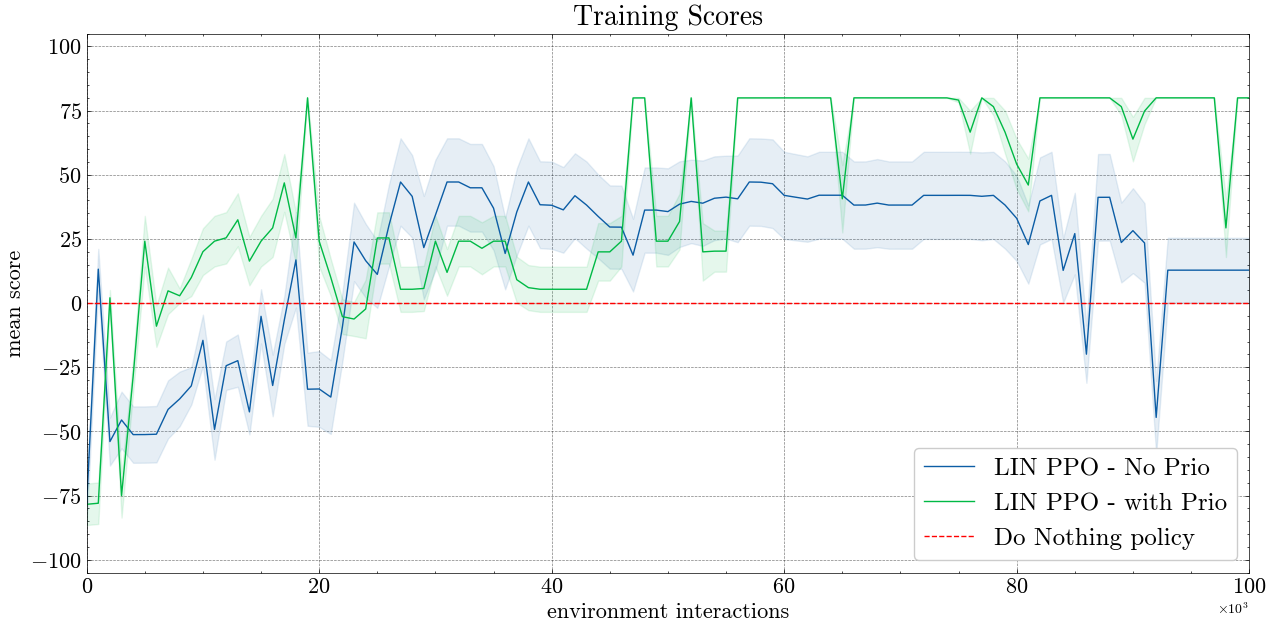

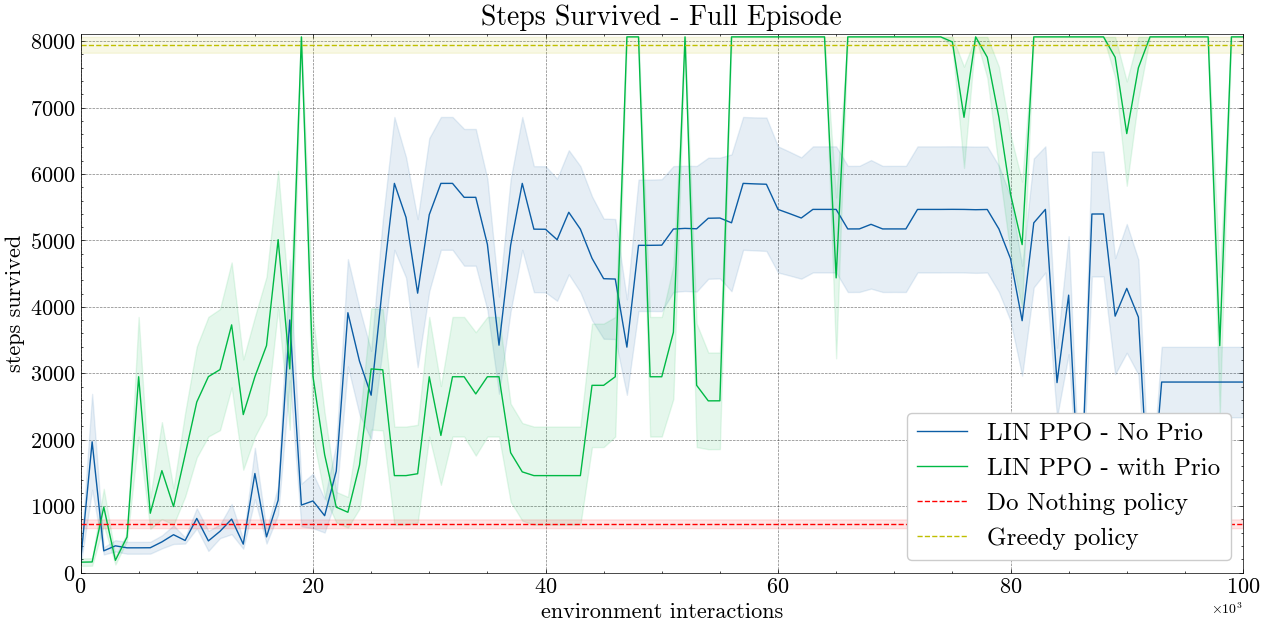

In [33]:
cases = [
    "case_14_FullEp_LIN_NoPrio13_ppo_0",
    "case_14_FullEp_tr13Par_LIN_ppo_0"
]

steps = []
full_scores = []
for case in cases:
    full_scores.append(pd.read_csv(f"{res_dir}/{case}/full_score.csv"))
    full_scores[-1] = full_scores[-1].rename(columns={"Env_Interactions": "env_interactions"})
    steps.append(pd.read_csv(f"{res_dir}/{case}/step.csv", names=full_scores[-1].columns[1::]))
    steps[-1]["env_interactions"] = full_scores[-1]["env_interactions"]

cases = [
    "LIN PPO - No Prio",
    "LIN PPO - with Prio",
]
max_steps = steps[-1].iloc[:, :-1].max().max() + 50

figure = compare_results(cases, full_scores, style=['science', 'grid', 'no-latex'], nb_steps = 100_000)
plt.show()
figure = compare_results(cases, steps, style=['science', 'grid', 'no-latex'], nb_steps = 100_000, ymin=0, ymax=max_steps, ylabel="steps survived", title="Steps Survived - Full Episode")

In [31]:
greedy = pd.read_csv(f"{res_dir}/case_14_greedy/full_score.csv") 
greedy.empty

True

# Test Partial Episode training

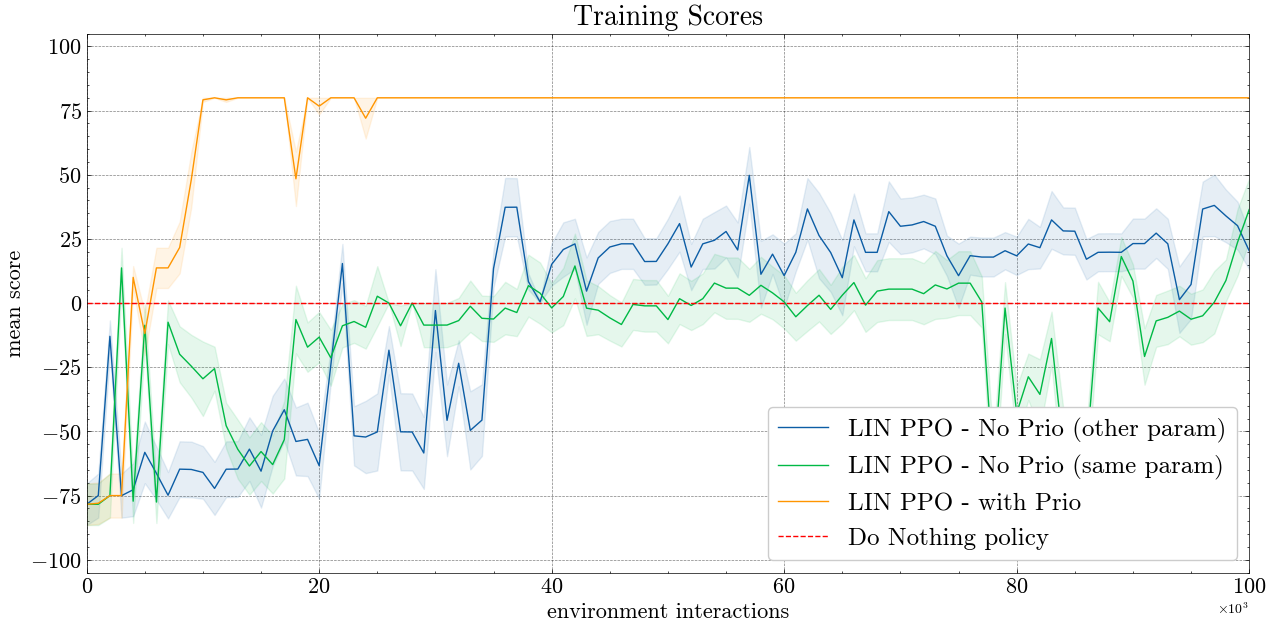

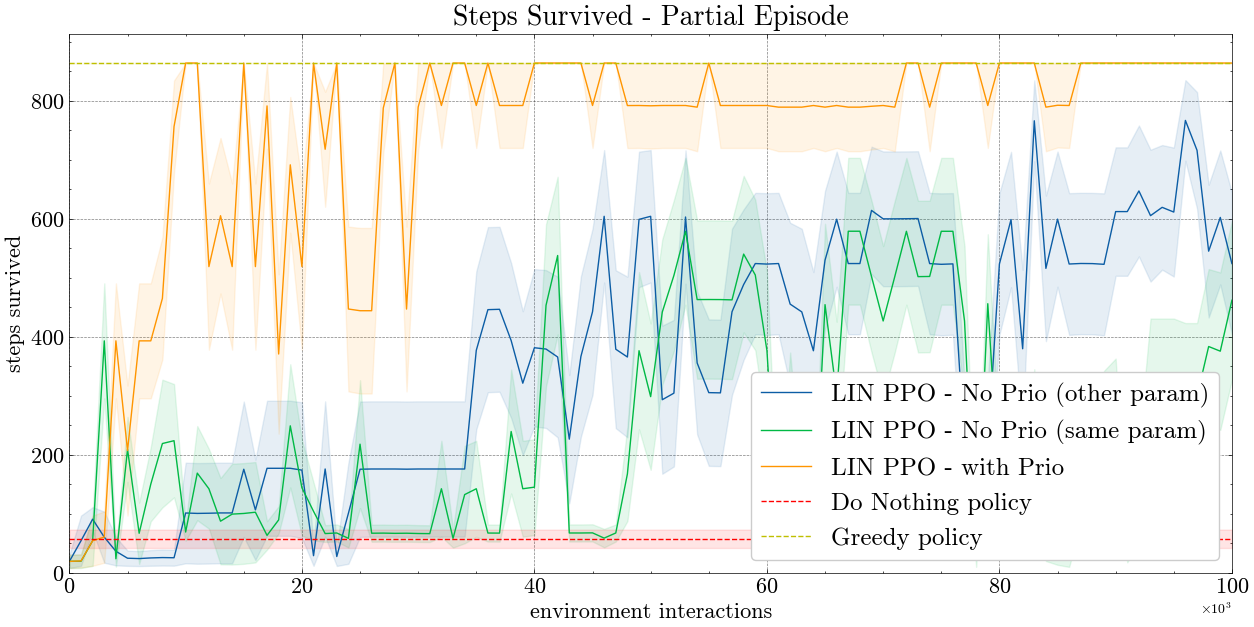

In [34]:
cases = [
    "case_14_PartEp_LIN_NoPrio_ppo_0", 
    "case_14_PartEp_LIN_NoPrio13_ppo_0",
    "case_14_PartEp_LIN_Prio13_ppo_0"
]

steps = []
full_scores = []
for case in cases:
    full_scores.append(pd.read_csv(f"{res_dir}/{case}/full_score.csv"))
    full_scores[-1] = full_scores[-1].rename(columns={"Env_Interactions": "env_interactions"})
    steps.append(pd.read_csv(f"{res_dir}/{case}/step.csv", names=full_scores[-1].columns[1::]))
    steps[-1]["env_interactions"] = full_scores[-1]["env_interactions"]

cases = [
    "LIN PPO - No Prio (other param)", 
    "LIN PPO - No Prio (same param)",
    "LIN PPO - with Prio",
]
max_steps = steps[-1].iloc[:, :-1].max().max() + 50

figure = compare_results(cases, full_scores, style=['science', 'grid', 'no-latex'], nb_steps = 100_000)
plt.show()
figure = compare_results(cases, steps, style=['science', 'grid', 'no-latex'], nb_steps = 100_000, ymin=0, ymax=max_steps, ylabel="steps survived", title="Steps Survived - Partial Episode", full=False)

dir:	 
name:	 FullEp_PPO_OptimalParams_1revisit
load_agent:	 
seed:	 0
case:	 14
reward:	 loss
gpuid:	 0
memlen:	 50000
nb_steps:	 50000
eval_steps:	 1000
mask:	 3
max_reward:	 10
input:	 ['p_i', 'r', 'o', 'd', 'm']
forecast:	 0
danger:	 0.9
middle_agent:	 capa
agent:	 ppo
network:	 lin
head_number:	 8
state_dim:	 128
n_history:	 6
dropout:	 0.0
n_layers:	 3
lr:	 0.0013
gamma:	 0.996
batch_size:	 16
update_start:	 5
rule:	 c
threshold:	 0.1
target_update:	 1
tau:	 0.001
target_entropy_scale:	 0.98
epsilon:	 0.18
entropy:	 0.05
lambda:	 0.91


,Max steps,Agent updates (steps),Best mean,Agent updates (mean)
seed,,,,
0,864.0,16.0,97.995799,18.0
1,864.0,43.0,88.336400,43.0
2,753.4,83.0,62.077546,12.0
3,622.2,44.0,54.428854,39.0


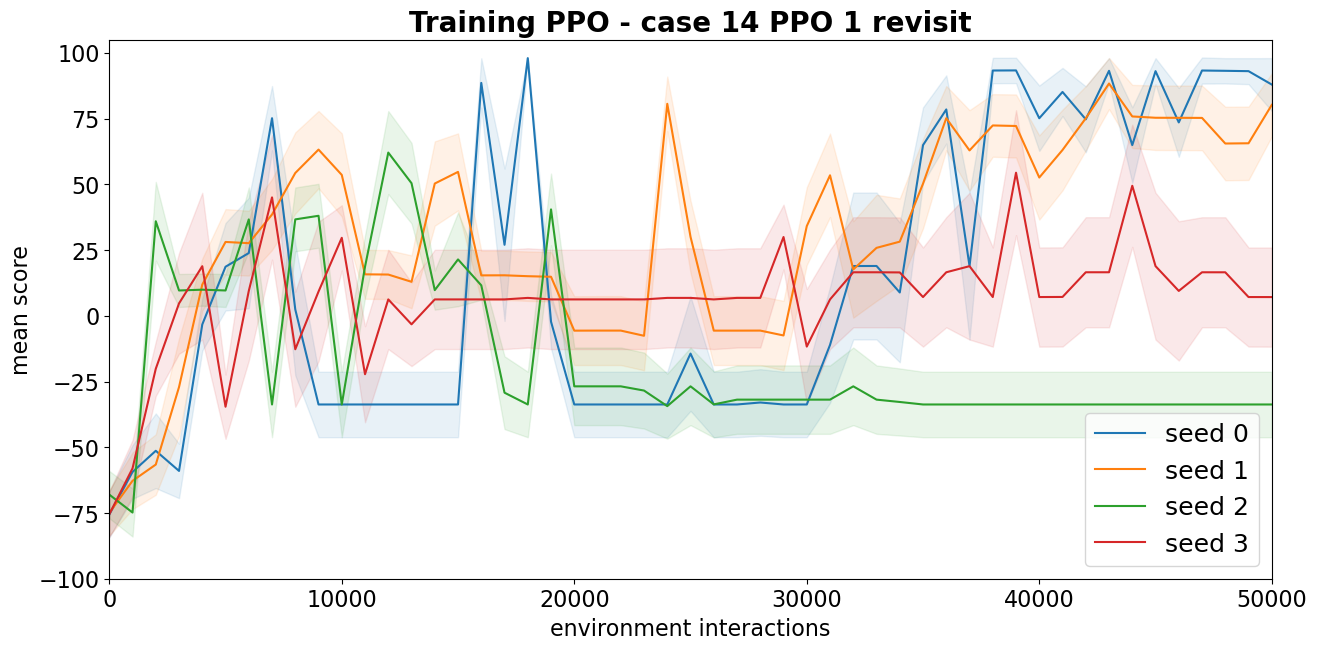

In [10]:
case = 'FullEp_PPO_1revisit'
seeds = 4
summary, res_ppo14_lin = show_results(res_dir, case, seeds, name='PPO 1 revisit')
summary

dir:	 /scratch-local/evandersar.5131360/evds_output_dir
name:	 PartEp_LIN_Prio13NoDiff
load_agent:	 
seed:	 0
case:	 14
reward:	 loss
train_full:	 False
test_full:	 True
no_prio:	 False
gpuid:	 0
memlen:	 50000
nb_steps:	 100000
eval_steps:	 1000
mask:	 3
max_reward:	 10
input:	 ['p_i', 'r', 'o', 'd', 'm']
forecast:	 0
danger:	 0.9
middle_agent:	 capa
agent:	 ppo
network:	 lin
head_number:	 8
state_dim:	 128
n_history:	 6
dropout:	 0.0
n_layers:	 3
lr:	 0.0013
gamma:	 0.996
batch_size:	 16
update_start:	 5
rule:	 c
threshold:	 0.1
target_update:	 1
tau:	 0.001
target_entropy_scale:	 0.98
epsilon:	 0.18
entropy:	 0.05
lambda:	 0.91


,Max steps,Agent updates (steps),Best mean,Agent updates (mean)
seed,,,,
0,200.8,44.0,8.520521,44.0
1,864.0,62.0,88.335180,84.0


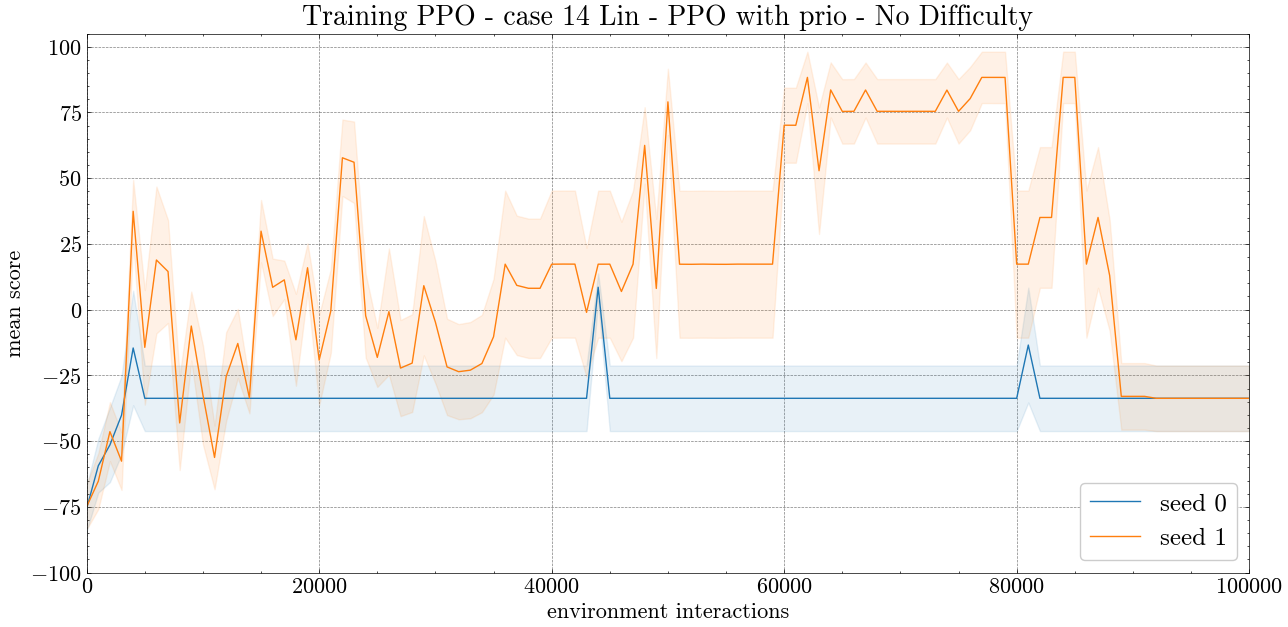

In [37]:
case = 'case_14_PartEp_LIN_Prio13NoDiff_ppo'
seeds = 2
summary, res_ppo14_lin = show_results(res_dir, case, seeds, name='Lin - PPO with prio - No Difficulty')
summary